# Audio classification of Cafe/Restaurant Noises using CNN

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Modules/FinalYearProject/Implementation

In [3]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

## Generate spectrograms

The "dataset" directory contains subdirectories for different types of cafe noises.

The first step is to load the WAV files, use a Python package named [Librosa](https://librosa.org/) to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [4]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path, classes):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for class_name in classes:
        class_input_path = os.path.join(input_path, class_name)
        class_output_path = os.path.join(output_path, class_name)
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)

        files = os.listdir(class_input_path)
        for file in files:
            input_file = os.path.join(class_input_path, file)
            output_file = os.path.join(class_output_path, file.replace('.wav', '.png'))
            create_spectrogram(input_file, output_file)

Create PNG files containing spectrograms from all the WAV files in the "dataset" directory.

In [5]:
dataset_folder = 'dataset'
save_folder = 'spectrograms'
classes = ['babble', 'cafeteria', 'chatter','cocktailparty', 'downstairs', 'patronsonly','soundproofed', 'tableforone', 'tableinfront', 'waiting']
create_pngs_from_wavs(dataset_folder, save_folder, classes)

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [6]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x = []
y = []

Load the background spectrogram images, add them to the list named `x`, and label them with 0s.

In [7]:
# Loop over each class name
for i, class_name in enumerate(classes):
    # Load the images and labels from the path
    images, labels = load_images_from_path(f'spectrograms/{class_name}', i)

    # Add the images and labels to the lists
    x += images
    y += labels

Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Build and train a CNN

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a `softmax` layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN.

In [9]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(10, activation='softmax')) #num_classes
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

Train the CNN and save the `history` object returned by `fit` in a local variable.

In [10]:
# hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Plot the training and validation accuracy.

In [11]:
# acc = hist.history['accuracy']
# val_acc = hist.history['val_accuracy']
# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, '-', label='Training Accuracy')
# plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.plot()

The accuracy is decent given that the network was trained with just 280 images, but it might be possible to achieve higher accuracy by employing transfer learning.

## Use transfer learning to improve accuracy

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. Let's use [`MobileNetV2`](https://keras.io/api/applications/mobilenet/), a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

> `MobileNetV2` requires less processing power and has a smaller memory footprint than CNNs such as `ResNet50V2`. That's why it is ideal for mobile devices. You can learn more about it in the [Google AI blog](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

Start by calling Keras's [MobileNetV2](https://keras.io/api/applications/mobilenet/) function to instantiate `MobileNetV2` without the classification layers. Use the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input) function for `MobileNet` networks to preprocess the training and testing images. Then run both datasets through `MobileNetV2` to extract features.

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step


Define a neural network to classify features extracted by `MobileNetV2`.

In [13]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax')) #num_classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Niamat-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the network with features extracted by `MobileNetV2`.

In [14]:
hist = model.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - accuracy: 0.5586 - loss: 29.4037 - val_accuracy: 0.9333 - val_loss: 1.1643
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 406ms/step - accuracy: 0.9502 - loss: 1.0061 - val_accuracy: 0.9028 - val_loss: 3.3130
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - accuracy: 0.9690 - loss: 0.6010 - val_accuracy: 0.9000 - val_loss: 3.9985
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.9761 - loss: 0.3373 - val_accuracy: 0.9583 - val_loss: 0.8036
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - accuracy: 0.9938 - loss: 0.1478 - val_accuracy: 0.9861 - val_loss: 0.3138
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.9922 - loss: 0.0969 - val_accuracy: 0.9778 - val_loss: 0.5643
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - accuracy: 0.9772 - loss: 0.5644 - val_accuracy: 0.8556 - val_loss: 5.0095
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.9554 - loss: 0.9519 - val_acc

Plot the training and validation accuracy.

[]

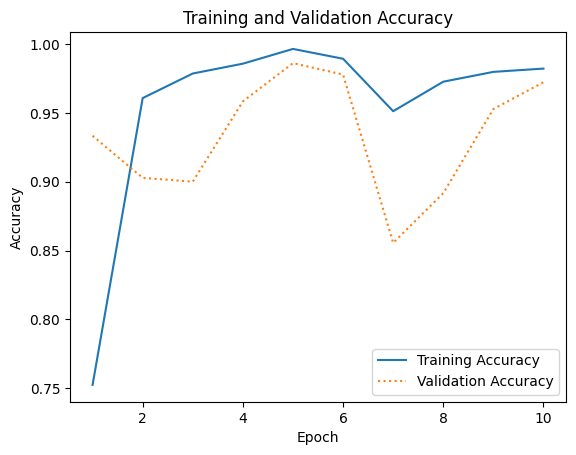

In [15]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run the test images through the network and use a confusion matrix to assess the results.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Text(110.44999999999997, 0.5, 'Actual label')

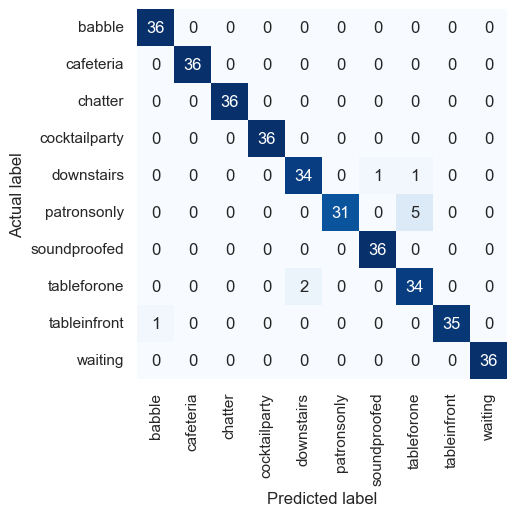

In [16]:
sns.set_theme()

y_predicted = model.predict(test_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['babble', 'cafeteria', 'chatter','cocktailparty', 'downstairs', 'patronsonly','soundproofed', 'tableforone', 'tableinfront', 'waiting']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [19]:
model.save('audio_model.keras')

The network is pretty adept at identifying clips that don't contain the sounds of chainsaw or engines. It sometimes confuses chainsaw sounds and engine sounds, but that's OK, because the presence of either might indicate illicit activity in a rain forest.

## Test with unrelated WAV files

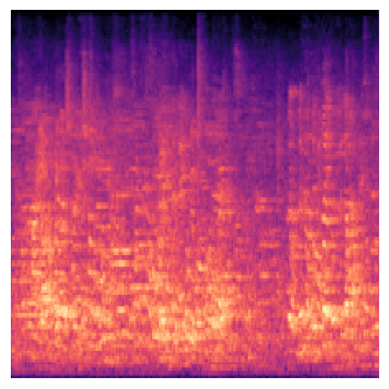

In [21]:
create_spectrogram('samples/sample.wav', 'spectrograms/sample.png')

x = image.load_img('spectrograms/sample.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the spectrogram image, pass it to `MobileNetV2` for feature extraction, and classify the features.

In [22]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
babble: 6.245961134077263e-29
cafeteria: 0.0
chatter: 0.0
cocktailparty: 0.0
downstairs: 8.321805421615514e-16
patronsonly: 0.05389174446463585
soundproofed: 0.0
tableforone: 0.9461079239845276
tableinfront: 3.7233884883316375e-16
waiting: 3.800204524395667e-07
